<h1><center> Customised BERT Family Classsifiers for Emotion Analysis</center></h1>  
<h2><center>BERT, DistilBERT, RoBERTa</center></h2>

<h3><center>INM706 - Deep Learning for Sequence Analysis </center></h3>

<center>A. Ascencio-Cabral<center>


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%%capture
!pip install transformers 

In [3]:
%%capture
!pip install torchmetrics

In [4]:
%%capture
!pip install gensim

In [5]:
%%capture
!pip install emot
!pip install scikit-posthocs

<h2> 1. Libraries </h2> 

In [6]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import gensim.downloader as api
import time
import emot
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SequentialSampler
from transformers import BertModel, DistilBertModel,  RobertaModel
from transformers import BertTokenizerFast, DistilBertTokenizerFast, RobertaTokenizerFast
from transformers import BertConfig, DistilBertConfig, RobertaConfig
from transformers import get_linear_schedule_with_warmup
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from torch.optim.lr_scheduler import OneCycleLR
from datetime import date
from tqdm import tqdm
from natsort import natsorted
%matplotlib inline
seed_= 1000
torch.manual_seed(seed_)
np.random.seed(seed_)

plt.style.use('ggplot')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [7]:
os.chdir('/content/drive/MyDrive/INM706')

In [1]:
from evaluation_metrics import Metrics, train_metrics
from comparison import save_file, get_metrics

<h2> 2. Emotion Dataset </h2> 



<h3 id="reviewing_data"> 2.1 About the dataset</h3>

**`emotions.csv`:** 
The dataset comprises emotional content (tweets), tweet id, author and a single categorical label per content id. It has in total 40,000 tweets of emotional content. A subset of this data was used in a project for Microsoft's Cortana Intelligence Gallery. 
The dataset was added to DataWorld on July 15, 2016 by CrowdFlower and can be sourced from:
https://www.crowdflower.com/data-for-everyone/

<h3> 2.2 Downloading the dataset </h3>


To download the data from dataworld we will use !wget
https://query.data.world/s/m3dkicscou2wd5p2d2ejd7ivfkipsg

In [ ]:
# !wget -O emotions.csv https://query.data.world/s/m3dkicscou2wd5p2d2ejd7ivfkipsg

<h3> 2.3 Reading the data from the CSV file </h3>  

In [9]:
df = pd.read_csv('./emotions.csv')
df.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


<h3> 2.4 Verifying that there are no empty cells </h3> 

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   author     40000 non-null  object
 3   content    40000 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [11]:
#review the sentiment instances
print('Num of instances: {}'.format(len(df)))

Num of instances: 40000


In [12]:
df[['sentiment']].describe()

,sentiment
count,40000
unique,13
top,neutral
freq,8638


<h3> 2.5 Data visualisation </h3> 

Let's visualise the emotions distribution in the dataset.

Text(0.5, 0, 'Emotion')

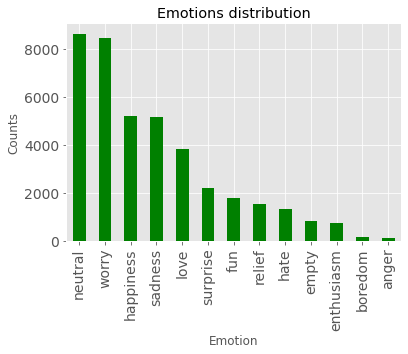

In [13]:
df.sentiment.value_counts().plot.bar(color='green', fontsize=14)
plt.title("Emotions distribution")
plt.ylabel("Counts")
plt.xlabel("Emotion")

In [14]:
df[['sentiment']].value_counts()

sentiment 
neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
dtype: int64

<h2> 3. Pre-processing and data selection </h2>
    

* Here we will first look for emoticons or/and emojis in the content. Then we will replace any emoticons or emojis with text by using the emot library.

* The similarity amongst emotions will be computed by using Google-news and Twitter pretrained vector models. 
* We will group the labels that are closer in similarity except if they have opposite meaning.
* Finally, we will drop label or labels that are highly similar with all other emotion labels.


In [15]:
# Extract the number of tweets of emotions with less instances in the dataset
anger = df[df['sentiment']== 'anger']
print('Anger: {} tweets'.format(len(anger)))
boredom = df[df['sentiment']== 'boredom']
print('Boredom: {} tweets'.format(len(boredom)))


Anger: 110 tweets
Boredom: 179 tweets


<h3> 3.1 Emoticon dictionary </h3>

In [16]:
emot_dict = emot.emo_unicode.EMOTICONS_EMO
# From Wikipedia list of emoticons correct to angry, 
# https://en.wikipedia.org/wiki/List_of_emoticons
emot_dict = {k: ('angry' if k in ['>-(', '>:(', '>:['] else v) for k, v in emot_dict.items()}


In [17]:
# From wikipedia remove andry 
emot_dict = {k: ('Frown, sad or pouting' if v == 'Frown, sad, andry or pouting' 
                 else v) for k, v in emot_dict.items()}

<h3> 3.2 Find emoticons in content </h3>

In [18]:
# Find the emoticons used in the tweets and their categorical label
emo = defaultdict(list)
for k, v in emot_dict.items():
    for i, l in enumerate(list(df.content)):
        a = df.sentiment.iloc[i]
        if k in l and a not in emo[k]:
            emo[k].append(a)

In [19]:
print('A total {} emoticons were used in the dataset.'.format(len(emo)))

A total 53 emoticons were used in the dataset.


In [20]:
# Show the emoticon and the content class label
data = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in emo.items()]))
data.head()

,:],:3,8-),:o),:^),=],8D,XD,=D,=3,...,:&,0:3,%),;_;,;;,T.T,QQ,o_0,o.O,oO
0,happiness,neutral,worry,neutral,sadness,sadness,surprise,neutral,sadness,neutral,...,worry,worry,neutral,sadness,surprise,sadness,neutral,neutral,worry,fun
1,worry,worry,happiness,love,neutral,happiness,worry,worry,enthusiasm,NaN,...,surprise,surprise,NaN,NaN,sadness,relief,NaN,worry,NaN,surprise
2,sadness,sadness,NaN,NaN,NaN,fun,neutral,love,happiness,NaN,...,love,sadness,NaN,NaN,happiness,neutral,NaN,NaN,NaN,worry
3,love,empty,NaN,NaN,NaN,worry,relief,enthusiasm,neutral,NaN,...,happiness,enthusiasm,NaN,NaN,worry,NaN,NaN,NaN,NaN,neutral
4,neutral,happiness,NaN,NaN,NaN,love,happiness,hate,love,NaN,...,sadness,neutral,NaN,NaN,hate,NaN,NaN,NaN,NaN,sadness


In [21]:
# Show information of the emoticons and number of different content labels that they appear
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 53 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   :]      10 non-null     object
 1   :3      12 non-null     object
 2   8-)     2 non-null      object
 3   :o)     2 non-null      object
 4   :^)     2 non-null      object
 5   =]      6 non-null      object
 6   8D      5 non-null      object
 7   XD      10 non-null     object
 8   =D      9 non-null      object
 9   =3      1 non-null      object
 10  :c      1 non-null      object
 11  :[      4 non-null      object
 12  :{      1 non-null      object
 13  :@      6 non-null      object
 14  :'(     6 non-null      object
 15  :')     3 non-null      object
 16  D:      9 non-null      object
 17  D8      1 non-null      object
 18  D;      3 non-null      object
 19  D=      2 non-null      object
 20  DX      3 non-null      object
 21  :O      8 non-null      object
 22  :o      7 non-null      obje

In [22]:
# Find emoticons with content labelled with 5 or more categories
for k,v in emo.items():
    if len(v) >= 5:
        print('Emoticon {0} - {1} appears in content with {2} different labels.'.format(k, emot_dict[k], len(v)))
        print('Labels: {}'.format(v))

Emoticon :] - Happy face or smiley appears in content with 10 different labels.
Labels: ['happiness', 'worry', 'sadness', 'love', 'neutral', 'empty', 'enthusiasm', 'surprise', 'boredom', 'fun']
Emoticon :3 - Happy face smiley appears in content with 12 different labels.
Labels: ['neutral', 'worry', 'sadness', 'empty', 'happiness', 'love', 'surprise', 'hate', 'boredom', 'relief', 'enthusiasm', 'fun']
Emoticon =] - Happy face smiley appears in content with 6 different labels.
Labels: ['sadness', 'happiness', 'fun', 'worry', 'love', 'neutral']
Emoticon 8D - Laughing, big grin or laugh with glasses appears in content with 5 different labels.
Labels: ['surprise', 'worry', 'neutral', 'relief', 'happiness']
Emoticon XD - Laughing, big grin or laugh with glasses appears in content with 10 different labels.
Labels: ['neutral', 'worry', 'love', 'enthusiasm', 'hate', 'happiness', 'surprise', 'relief', 'empty', 'fun']
Emoticon =D - Laughing, big grin or laugh with glasses appears in content with 9

<h3> 3.3 Find tweets with emojis </h3>

In [23]:
emoji = list()
for i, l in enumerate(list(df.content)):
    if 'U+'in l:
        emoji.append(i)
if len(emoji)==0:
    print('No emojies in the dataset')

No emojies in the dataset


The dataset content did not have emojis.

<h3> 3.4 Finding similarity in emotions using Gensim </h3>

From the section 3.2 we observed that some emoticons appear in content that has been labelled differently.  For instance the emoticon happy face or smiley appears in content labelled as 'happiness', 'worry', 'sadness', 'love', 'neutral', 'empty', 'enthusiasm', 'surprise', 'boredom' and 'fun'. These
findings show that the emoticon and content can be ambiguous, expressing different feelings at
once. It also could be mislabelled or the incorrect emoticon used since the emoticons were manually input rather than automatically generated from text. Therefore, this dataset represents a challenge for a classification task. To address this issue we will follow the strategy below:

* Replace the following labels that are adjectives and/or verbs with nouns; empty with emptiness, and hate with hatred.
* Load pretrained word2vec-google-news-300 and 'glove-twitter-100 vectors and compute similitariy amongst the categorical labels (emotion).
* Join similar emotions 
* Remove instances of labels that are related with all labels.

In [66]:
df_emotions = df.copy()

In [67]:
df_emotions.loc[(df_emotions.sentiment == 'empty'), 'sentiment'] = 'emptiness'
df_emotions.loc[(df_emotions.sentiment == 'hate'), 'sentiment'] = 'hatred'

In [68]:
emotions_m = sorted(list(df_emotions.sentiment.unique()))

In [69]:
%%capture
# Load google-new word2vec vectors
gwv = api.load('word2vec-google-news-300')

# Load glove-twitter vectors 
glove_vectors = api.load('glove-twitter-100') 


In [70]:
# Compute similarity from pre-trained models
sim_g ={}
sim_t ={}

for e in emotions_m:
    for i in range(len(emotions_m)-1):
        # google news
        w1 = e
        w2 = emotions_m[i+1] 
        if w1 == w2:
            continue    
        key = (w1, w2)
        if key[::-1] in sim_g.keys(): 
              continue
        else: 
            # google vectors
            similarity_g = gwv.similarity(w1, w2)
            # twitter vectors
            similarity_t = glove_vectors.similarity(w1, w2)
            sim_g[key] = similarity_g
            sim_t[key] = similarity_t

In [71]:
# Sort by google-news similarity
similarity= pd.DataFrame([sim_t, sim_g]).T
similarity.columns = ['twitter', 'goog_news']
similarity = similarity.sort_values(by= 'goog_news', ascending = False)
similarity.head(20)

,twitter,goog_news
"(anger, hatred)",0.768769,0.590178
"(emptiness, sadness)",0.550510,0.589492
"(fun, love)",0.710840,0.466562
"(anger, sadness)",0.702778,0.451019
"(happiness, love)",0.628533,0.450275
"(boredom, emptiness)",0.361649,0.450142
"(emptiness, happiness)",0.430916,0.439732
"(happiness, sadness)",0.724261,0.426663
"(anger, enthusiasm)",0.503019,0.408466
"(hatred, sadness)",0.627424,0.395898


In [72]:
# Sort by twitter similarity
similarity_t = similarity.copy()
similarity_t =similarity_t.sort_values(by= 'twitter', ascending = False)
similarity_t.head(20)


,twitter,goog_news
"(anger, hatred)",0.768769,0.590178
"(happiness, sadness)",0.724261,0.426663
"(fun, love)",0.710840,0.466562
"(anger, sadness)",0.702778,0.451019
"(love, worry)",0.646493,0.314854
"(fun, worry)",0.637802,0.272918
"(happiness, worry)",0.630607,0.191000
"(happiness, love)",0.628533,0.450275
"(hatred, sadness)",0.627424,0.395898
"(fun, surprise)",0.619150,0.202897


In [73]:
# Similarities to relief
for k in sim_t:
    if 'relief' in k:
        print(k, sim_t[k])
        

('anger', 'relief') 0.4591962
('boredom', 'relief') 0.3327248
('emptiness', 'relief') 0.24379823
('enthusiasm', 'relief') 0.29858676
('fun', 'relief') 0.353736
('happiness', 'relief') 0.40495405
('hatred', 'relief') 0.40448517
('love', 'relief') 0.3014868
('neutral', 'relief') 0.27753094
('relief', 'sadness') 0.32705474
('relief', 'surprise') 0.33689827
('relief', 'worry') 0.30643463


<h3> 3.5 Aggregating emotions </h3>

-  **anger** - hatred and anger
-  **happiness** - enthusiasm, fun, love, hapiness, relief, surprise
-  **neutral** - neutral
-  **sadness** - boredom, emptiness and sadness
-  **worry** - worry dropped

In [74]:
# Change column name from sentiment to emotion
df_emotions.rename(columns = {'sentiment':'emotion'}, inplace=True)

In [76]:
df_emotions.emotion.replace({'hatred': 'anger', 'emptiness': 'sadness', 'boredom':'sadness', 
                      'fun': 'happiness', 'love': 'happiness', 'enthusiasm': 'happiness', 
                      'surprise': 'happiness', 'relief': 'happiness'}, inplace=True)


In [77]:
# Removing worry 
df_emotions = df_emotions[df_emotions.emotion != 'worry']


<h3> 3.6 Removing unnecesary column </h3>

In [78]:
df_emotions = df_emotions[['emotion','content']]
df_emotions.head(5)


,emotion,content
0,sadness,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,happiness,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


Let's review the unique emotions

In [79]:
df_emotions['emotion'].value_counts()

happiness    15299
neutral       8638
sadness       6171
anger         1433
Name: emotion, dtype: int64

In [80]:
# Extract the unique emotions
emotions = sorted(list(df_emotions['emotion'].unique()))
print(emotions)

['anger', 'happiness', 'neutral', 'sadness']


<h3> 3.7 Assigning  encoded labels </h3>

In [81]:
# Creating the label dictionary
emo_to_label = {em:i for i, em in enumerate(emotions)}
print(emo_to_label)

{'anger': 0, 'happiness': 1, 'neutral': 2, 'sadness': 3}


In [82]:
# Get the class from encoded label
label_to_emotion = {i:em for i, em in enumerate(emotions)}

<h3> 3.8 Creating the encoded labels</h3>

In [83]:
label = [emo_to_label[em] for em in df_emotions.emotion]

In [85]:
# df_emotions['label']=label
df_emotions.insert(2, 'label', label )

In [86]:
df_emotions.head()

,emotion,content,label
0,sadness,@tiffanylue i know i was listenin to bad habi...,3
1,sadness,Layin n bed with a headache ughhhh...waitin o...,3
2,sadness,Funeral ceremony...gloomy friday...,3
3,happiness,wants to hang out with friends SOON!,1
4,neutral,@dannycastillo We want to trade with someone w...,2


<h2> 4. Dataset subsets </h2>

Here we will replace any emoticons with test and split the dataset in three subsets: training, validation and test.  

<h3> 4.1 Replace emoticons </h3>

In [87]:
def replace_emoticons(text):
    """
    :param text: text to process
    :return: text with emoticons converted to text 
    """
    for em in emot_dict:
        text = text.replace(em, emot_dict[em].replace(" ","_"))
    return text

In [88]:
# replace emoticons 
replace_emot = True
if replace_emot:
    for r, t in enumerate(df_emotions.content):
        t = replace_emoticons(t)
        df_emotions.iat[r, 1] = t

<h3> 4.2 Splitting the dataset </h3>

To address the class imbalace the dataset will be split by label stratification using scikit-learn train_test_split function.

In [89]:
X = df_emotions.content.values
y = df_emotions.label.values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, stratify=y, 
                                                  random_state= seed_)

In [90]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val,
                                                random_state= seed_)


<h3> 4.3 Visualisation of emotion distribution </h3>

Text(0.5, 0, 'Emotion')

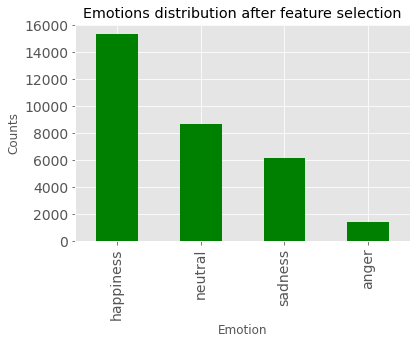

In [91]:
df_emotions.emotion.value_counts().plot.bar(color='green', fontsize=14)
plt.title("Emotions distribution after feature selection")
plt.ylabel("Counts")
plt.xlabel("Emotion")

<h3> 4.4 Verifying the instances per split </h3>

In [92]:
print('Train data: {}'.format(len(X_train)))
print('Val data: {}'.format(len(X_val)))
print('Test data: {}'.format(len(X_test)))

Train data: 25232
Val data: 3154
Test data: 3155


In [93]:
class_count_train = {}
class_count_val = {}
class_count_test = {}

for label in emo_to_label:
    class_count_train[label] = np.count_nonzero(y_train == emo_to_label[label])

for label in emo_to_label:
    class_count_val[label] = np.count_nonzero(y_val == emo_to_label[label])

for label in emo_to_label:
    class_count_test[label] = np.count_nonzero(y_test == emo_to_label[label])
    
print('Classes intances in train dataset {}'.format(class_count_train))
print('Classes intances in validation dataset {}'.format(class_count_val)) 
print('Classes intances in test dataset {}'.format(class_count_test))   


Classes intances in train dataset {'anger': 1146, 'happiness': 12239, 'neutral': 6910, 'sadness': 4937}
Classes intances in validation dataset {'anger': 143, 'happiness': 1530, 'neutral': 864, 'sadness': 617}
Classes intances in test dataset {'anger': 144, 'happiness': 1530, 'neutral': 864, 'sadness': 617}


<h2> 5. Visualizing the size of the tweets </h2>

In [94]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased',
                                               clean_text=True)

In [95]:
len_tokens = list()
for txt in df_emotions.content:
    # Half of BERT length
    tokens = tokenizer.encode(txt, truncation=True, max_length=256) 
    len_tokens.append(len(tokens))


In [96]:
print('Max tokens: {}, min tokens: {}'.format(max(len_tokens), min(len_tokens)))

Max tokens: 123, min tokens: 3


Text(0.5, 0, 'Token count')

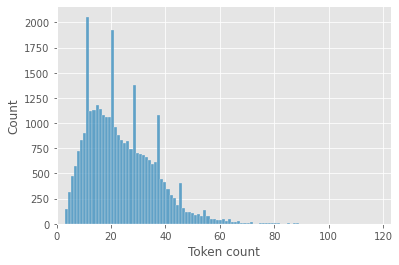

In [97]:
sns.histplot(len_tokens)
plt.xlim([0, 123])
plt.xlabel('Token count')

The histogram shows that most of the tweets have under 60 tokens and maximum of 123. We will use the maximun length of 125 for our models.

<h2> 6. Built customised dataset constructor, classifier methods and training function </h2>

<h3> 6.1 Building the data class to feed to the model </h3>

In [98]:
class EmotionsDataset(Dataset):

    def __init__(self, content, targets, tokenizer, max_length):
        self.content = content
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_length = max_length
  
    def __getitem__(self, idx):
        tweet = str(self.content[idx])
        target = self.targets[idx]

        encoded_sent = self.tokenizer.encode_plus(tweet,
          add_special_tokens=True,
          return_token_type_ids=False,
          max_length = self.max_length,
          padding = 'max_length',
          truncation = True,
          return_attention_mask=True,
          return_tensors='pt')

        o = dict()
        o['attention_mask'] = encoded_sent['attention_mask'].flatten()
        o['input_ids'] = encoded_sent['input_ids'].flatten()
        o['sent_text'] = tweet
        o['targets']= torch.tensor(target, dtype=torch.long)
        return o
   
    def __len__(self):

        return len(self.content)


<h3> 6.2 Building BERT, DistilBert and RoBERTa Multiclass Sequence Classifiers </h3>

In [99]:
class EmotionClassifiers(nn.Module):

    def __init__(self, base_model, hidden=None, num_classes=2, p=0.2, freeze_params=False):

        super(EmotionClassifiers, self).__init__()

        if hidden is None:
            hidden = [512, 512]
        self.base_model = base_model 
        self.num_classes = num_classes
        self.hidden = hidden
        self.dropout = nn.Dropout(p)
        self.classifier = nn.Sequential(
            nn.Linear(base_model.config.hidden_size, self.hidden[0]),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(self.hidden[0], self.hidden[1]),
            nn.Dropout(0.2),
            nn.Linear(self.hidden[1], self.num_classes))

        if freeze_params:
            for param in self.base_model.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):

        output = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = output[0]
        pooled_output = sequence_output[:, 0]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        return logits

<h3> 6.3 Training one epoch function </h3>

In [100]:
def train_one_epoch(model, data_loader, loss_fn, optimizer, scheduler):
    """
    :param model: model to train
    :param data_loader: constructor to pass batches of data to process
    :param loss_fn: loss/ cost function to minimise
    :param optimizer: optimizer to minimise the loss
    :param scheduler: policy to reduce the learning rate
    :return: running loss and accuracy
    """

    model = model.to(device)
    model.train()

    epoch_loss, correct = 0, 0

    for batch in data_loader:

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['targets'].to(device)

        optimizer.zero_grad()
        output = model(input_ids, attention_mask)
        loss = loss_fn(output, labels)
        epoch_loss += loss.item()
        
        preds = torch.argmax(output, dim=-1)
        correct += (preds == labels).sum().item()

        loss.backward()
        # nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) 
        # prevents exploding gradients
        optimizer.step()
        scheduler.step()

    return epoch_loss/len(data_loader),  correct/len(data_loader.dataset)

<h3> 6.4 Evalute function </h3>

In [101]:
def evaluate(model, data_loader):
    """
    :param model: model to evaluate
    :param data_loader: constructor to process the data
    :return: running loss and accuracy 
    """

    model.eval()

    loss_fn = nn.CrossEntropyLoss()

    eval_loss, correct = 0, 0

    with torch.no_grad():

        for batch in (data_loader):

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['targets'].to(device)
            # get logits
            output = model(input_ids, attention_mask) 
            # add loss
            eval_loss += loss_fn(output, labels).item()

            # compute predictions
            preds = torch.argmax(output, dim=-1) 
            correct += (preds == labels).sum().item()

    return eval_loss/len(data_loader), correct/len(data_loader.dataset)


<h3> 6.5 Building the main training function </h3>

In [102]:
def main(**kwargs):
    """
    :param kwargs: a dictionary to create the model , loader and parametert to train 
    and validate the model.
    :return: a dictionary with training stats, scheduler and the model.
    """

    train_dataset = EmotionsDataset(kwargs['x_train'], kwargs['y_train'], 
                                    kwargs['tokenizer'], max_length=125)
    val_dataset = EmotionsDataset(kwargs['x_val'], kwargs['y_val'], 
                                  kwargs['tokenizer'], max_length=125)

    model =  EmotionClassifiers(kwargs['base_model'], kwargs['hidden'],
                                kwargs['num_classes'], kwargs['dropout'])

    train_dataloader = DataLoader(train_dataset, batch_size=kwargs['batch'],
                                  shuffle=True, num_workers=2)
    val_dataloader = DataLoader(val_dataset, batch_size=kwargs['batch'], 
                                shuffle= True, num_workers=2)

    no_decay = ['bias', 'LayerNorm.weight']
    grouped_parameters = [{'params': [p for n, p in model.named_parameters()
                                          if not any(nd in n for nd in no_decay)],
                               'weight_decay': kwargs['decay']},
                              {'params': [p for n, p in model.named_parameters()
                                          if any(nd in n for nd in no_decay)], 
                               'weight_decay': 0.0}]

    optimizer = torch.optim.AdamW(grouped_parameters, lr=kwargs['lr'])
    total_steps = len(train_dataloader) * kwargs['epochs']

    if kwargs['scheduler'] == 'linear':
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,
                                             num_training_steps=total_steps)
    elif kwargs['scheduler'] == 'one_cycle':
        scheduler = OneCycleLR(optimizer, max_lr= kwargs['lr'], 
                               steps_per_epoch=len(train_dataloader), 
                               epochs=kwargs['epochs'], pct_start=0.2)
    else:
        assert kwargs['scheduler'] in ['linear', 'one_cycle'], \
            'Input linear or one_cycle scheduler'

    best_acc = -np.inf
    stats_log = defaultdict(list)
    n_steps = 0

    for epoch in tqdm(range(kwargs['epochs'])):

        epoch_start_time = time.time()

        train_loss, train_acc = train_one_epoch(model, train_dataloader,
                                                      kwargs['loss'], optimizer, scheduler)

        print(scheduler.get_last_lr())
        n_steps += len(train_dataloader)
        val_loss, val_acc = evaluate(model, val_dataloader)

        print('| End of epoch {:2d} | time: {:.2f}s | train loss {:.4f} | '
            'train_acc {:.2f}%'.format(epoch+1, (time.time() - epoch_start_time),
                                        train_loss, train_acc*100))

        print('| Steps {}| val loss {:.4f} | '
            'val_acc {:.2f}%'.format(n_steps, val_loss, val_acc*100))
     

        # save the best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save({
              'epoch': epoch + 1,
              'model': model.state_dict(),
              'optimizer': optimizer.state_dict(),'scheduler':scheduler.state_dict(),
              'acc': best_acc, 'lr': scheduler.get_last_lr(),
              'stats': stats_log
              }, os.path.join(kwargs['output_dir'], 'best_model_{}.pt'.format(kwargs['exp'])))
            print('saved')

        stats_log['train_acc'].append(train_acc)
        stats_log['train_loss'].append(train_loss)
        stats_log['val_acc'].append(val_acc)
        stats_log['val_loss'].append(val_loss)
        stats_log['steps'].append(n_steps)

    return stats_log, model, scheduler


<h2>7. Experimental setup</h2>

A total 24 experiments will be run as product of the combination of the following:
 
 - Base models - BERT, DistilBERT, RoBERTa
 - The loss function to be minimised - wCE and CE (Cross entropy and Weighted Cross entropy)
 - Schedulers - linear and one cycle learning rate policies
 - Learning rate - two rates at which the algorithm learns

In [103]:
exps =[i+1 for i in range(0, 24)]
models = ['bert', 'distilbert', 'roberta'] * 8
exp_loss= ['wCE' if i > 11 else 'CE' for i in range(0, 24)]
lr_rates = [8e-6 if i > 5 else 1e-5 for i in range(0, 12)] * 2
schedulers =  ['linear' if i > 2 else 'one_cycle' for i in range(0, 6)] * 4

In [104]:
setup = pd.DataFrame({'Exp':exps,'Network': models, 'Loss': exp_loss, 'lr':lr_rates, 
                      'scheduler': schedulers})
setup.set_index('Exp', inplace=True)


| Experiment |  Network   | Loss | Learning<br />rate | Learning<br/>policy |
|:----------:|:----------:|:----:|:------------------:|:-------------------:|
| 01         |    BERT    |  CE  |       1e-05        |     one\_cycle      |
| 02         | DistilBERT |  CE  |       1e-05        |     one\_cycle      |
| 03         |  RoBERTa   |  CE  |       1e-05        |     one\_cycle      |
| 04         |    BERT    |  CE  |       1e-05        |       linear        |
| 05         | DistilBERT |  CE  |       1e-05        |       linear        |
| 06         |  RoBERTa   |  CE  |       1e-05        |       linear        |
| 07         |    BERT    |  CE  |       8e-06        |     one\_cycle      |
| 08         | DistilBERT |  CE  |       8e-06        |     one\_cycle      |
| 09         |  RoBERTa   |  CE  |       8e-06        |     one\_cycle      |
| 10         |    BERT    |  CE  |       8e-06        |       linear        |
| 11         | DistilBERT |  CE  |       8e-06        |       linear        |
| 12         |  RoBERTa   |  CE  |       8e-06        |       linear        |
| 13         |    BERT    | wCE  |       1e-05        |     one\_cycle      |
| 14         | DistilBERT | wCE  |       1e-05        |     one\_cycle      |
| 15         |  RoBERTa   | wCE  |       1e-05        |     one\_cycle      |
| 16         |    BERT    | wCE  |       1e-05        |       linear        |
| 17         | DistilBERT | wCE  |       1e-05        |       linear        |
| 18         |  RoBERTa   | wCE  |       1e-05        |       linear        |
| 19         |    BERT    | wCE  |       8e-06        |     one\_cycle      |
| 20         | DistilBERT | wCE  |       8e-06        |     one\_cycle      |
| 21         |  RoBERTa   | wCE  |       8e-06        |     one\_cycle      |
| 22         |    BERT    | wCE  |       8e-06        |       linear        |
| 23         | DistilBERT | wCE  |       8e-06        |       linear        |
| 24         |  RoBERTa   | wCE  |       8e-06        |       linear        | 
    


<h3> 7.1 Loss function </h3>

- **Building weights for cross entropy loss fuction -Imbalaced dataset**

In [105]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                classes=np.unique(y_train), y=y_train)
weights = torch.tensor(class_weights, dtype=torch.float)

- __Building the loss function__

In [106]:
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html 

# Weights for imbalanced dataset - feed the weights to the cross entropy
w_criterion = nn.CrossEntropyLoss(weight=weights).to(device)

# Cross entropy
criterion = nn.CrossEntropyLoss().to(device)

<h3> 7.2 Preparing tokenizers and base models for training </h3>


- **Prepare tokenizers**

In [107]:
# Create the tokenizers
bert_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', 
                                                   clean_text=True)
dist_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased', 
                                                         clean_text=True)
rob_tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', 
                                                     clean_text=True)


- **Extract the base models to buil the classifiers**


In [108]:
# Get the base model to build the classifiers
bert = BertModel.from_pretrained('bert-base-uncased')
distbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
roberta = RobertaModel.from_pretrained('roberta-base')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm

<h2> 8. Training the classifier </h2>

<h3> 8.1 Training hyparameters </h3>

In [110]:
# Create an output diretory to store the weights
outdir = os.path.join(os.getcwd(), 'weights')
os.makedirs(outdir, exist_ok=True)

exp = 24
exp_model = setup.Network.loc[exp]
exp_loss = setup.Loss.loc[exp]
lr = setup.lr.loc[exp]
policy = setup.scheduler.loc[exp]

if exp_loss == 'CE':
    loss = criterion
else:
    loss = w_criterion

if exp_model == 'bert': 
    tokenizer = bert_tokenizer
    base_model = bert

if exp_model == 'distilbert': 
    tokenizer = dist_tokenizer
    base_model = distbert

else:
    tokenizer = rob_tokenizer
    base_model = roberta

# Dictionary of hyperameters to run the experiments
params = {'exp': exp, 'base_model': base_model, 'tokenizer': tokenizer, 
          'hidden': [768, 512], 'num_classes': len(emotions),'dropout': 0.3, 'batch': 16,
          'lr': lr, 'decay': 0.01, 'x_train': X_train, 'y_train': y_train, 'x_val': X_val,
          'y_val':y_val, 'loss': loss, 'epochs': 4, 'scheduler': policy, 
          'output_dir': outdir}

<h3> 8.2 Start training</h3>

In [ ]:
print('Exp: {} | Model: {} | Loss: {} | Learning rate: {} | '
      'Policy: {}'.format(exp, exp_model, exp_loss, lr, policy))

# Invoking method to start training
train_stats, model_, last_lr = main(**params)

In [ ]:
print('Last learning rate: ', last_lr.get_last_lr())

<h3> 8.3 Extracting performance metrics from training  and validation</h3>

In [116]:
tr_acc, tr_loss, v_acc, v_loss= train_metrics(**train_stats)

<h3> 8.4 Visualising training results </h3>

In [117]:
def plot_stats(exp=exp, hideplot=False, n_epochs=4, **stats):
    """
    :param hideplot: boolean to show or training and validation plot
    :param stats: a dictionary with the loss and accuracy for training and validation
    :return: plots for accuracy and  loss
    """
    
    plots_dir = os.path.join(os.getcwd(), 'plots')
    os.makedirs(plots_dir, exist_ok=True)
    
    # Plot the loss per epoch
    fig1 = plt.figure(figsize=(8,4))
    x =  np.arange(1,  n_epochs+1) 
    plt.plot(x, stats['train_loss'], label='train')
    plt.plot(x, stats['val_loss'], label='val')
    plt.xticks(range(1, n_epochs+1))
    plt.title("Loss trend")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(os.path.join(plots_dir, 'loss_{}.png'.format(exp)))
    if hideplot:
        plt.close(fig1)
    else:
        plt.rcParams.update({'font.size': 10})
        plt.show(fig1)

    # Plot accuracy per epoch
    fig2 = plt.figure(figsize=(8,4))
    x =  np.arange(1,  n_epochs+1) 
    plt.plot(x, stats['train_acc'], label='train')
    plt.plot(x, stats['val_acc'], label='val')
    plt.xticks(range(1, n_epochs+1))
    plt.title("Accuracy trend")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(os.path.join(plots_dir, 'acc_{}.png'.format(exp)))
    if hideplot:
        plt.close(fig2)
    else:
        plt.rcParams.update({'font.size': 10})
        plt.show(fig2)

    return fig1, fig2
    

In [ ]:
plot_stats(exp, hideplot=False, n_epochs=params['epochs'], **train_stats)

<h2> 9. Evaluate the model on the test dataset

### **Metrics**

- Accuracy 
- Balanced Accuracy
- F1 Score
- Matthew's Correlation Coefficient
- Precision
- Recall
- AUROC

<h3> 9.1 Build test dataset and dataloader </h3>

In [121]:
test_dataset = EmotionsDataset(X_test, y_test, params['tokenizer'], max_length=125)

In [122]:
prediction_sampler = SequentialSampler(test_dataset)

In [123]:
test_dataloader = DataLoader(test_dataset, batch_size= 16, sampler=prediction_sampler)

<h3>9.2 Load best trained weights onto model</h3>

In [124]:
checkpoint=torch.load(os.path.join(outdir, 'best_model_{}.pt'.format(params['exp'])))

In [ ]:
model_.load_state_dict(checkpoint['model'], strict=False)

<h3> 9.3 Get predictions </h3>

-  **Build function to read predictions**

In [126]:
def get_predictions(model, data_loader):
    """
    Calculates predictions on test dataset
    returns list of probabilities, true and predicted labels
    """

    model = model.eval()

    sent_texts = []
    predictions = []
    prediction_probs = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:

            texts = batch["sent_text"]
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            targets = batch["targets"].to(device)

            output = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            preds = torch.argmax(output, dim=1)
            probs = F.softmax(output, dim=1)

            sent_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.append(probs)
            true_labels.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.cat(prediction_probs)
    true_values = torch.stack(true_labels).cpu()

    return sent_texts, predictions, prediction_probs, true_values

- **Compute predictions and probabilities**

In [127]:
y_review_texts, y_pred, y_probs, y_true = get_predictions(
  model_, test_dataloader)

- **Save true labels**

In [128]:
if exp == 1:
    true_dir = os.path.join(os.getcwd(), 'true_labels')
    # create a directory for the true labels
    os.makedirs(true_dir, exist_ok=True)
    # save the true labels in npz format
    true_labels = save_file(y_true, true_dir, 'true_labels{}.npz'.format(exp))

In [129]:
# create a directory for the prediction
pred_path = os.path.join(os.getcwd(), 'predictions')
os.makedirs(pred_path, exist_ok=True)

# Save predictions in npz format
save_file(y_pred, pred_path, 'pred_exp{}.npz'.format(exp))

<h3> 9.4 Evaluation Metrics </h3>

In [130]:
metrics = Metrics(y_true, y_pred, y_probs, emotions)

In [ ]:
# Show confusion matrix
metrics.cmatrix()

In [ ]:
print('Classification report', metrics.classification_rep(), sep='\n')

In [ ]:
ba = metrics.balanced_acc()
mcc = metrics.mcc()
acc = metrics.acc()
auroc = metrics.auroc()
precision, recall, f1, pre_class, rec_class, f1_class = metrics.macro_average()

In [134]:
epoch= checkpoint['epoch'] 

In [135]:
metrics_ = [['Date', date.today()], ['exp', params['exp']],
            ['Architecture', exp_model], ['loss', exp_loss], 
            ['lr', params['lr']], ['Test acc', np.round(acc,4)], 
            ['scheduler', params['scheduler']], ['BA', np.round(ba, 4)], 
            ['F1 macro', np.round(f1, 4)],
            ['Recall', np.round(recall, 4)],
            ['Precision', np.round(precision, 4)],
            ['MCC', np.round(mcc, 4)],
            ['AUROC', np.round(auroc.item(),4)],
            ['F1 per class', np.round(f1_class, 4)],
            ['Recall per class', np.round(rec_class, 4)], 
             ['Pres per class', np.round(pre_class, 4)], ['epoch', epoch],
            ['train_acc', np.round(tr_acc, 4)], ['val_acc', np.round(v_acc, 4)]]

In [136]:
df_metrics = pd.DataFrame(metrics_, columns= ['Metric','Value'],
                          index = [i for i in range(len(metrics_))])

In [137]:
# Transpose  the evaluation results and saved them into csv file
df_metrics= df_metrics.T
df_metrics.rename(columns=df_metrics.iloc[0], inplace=True)
df_metrics.drop(df_metrics.index[0], inplace = True)

In [139]:
# Save metrics into csv file
fname = 'exp_' + str(exp) + '.csv'
stats_dir = os.path.join(os.getcwd(), 'metrics')
os.makedirs(stats_dir, exist_ok=True)
df_metrics.to_csv(os.path.join(stats_dir, fname))

<h3> 10. Ranking the models performance </h3>

In [140]:
eval_dir= 'metrics'
models_list = natsorted(os.listdir('metrics'))
models_list =  [m for m in models_list if m != '.DS_Store']

In [141]:
df2_metrics = get_metrics(models_list, eval_dir)

In [142]:
df2_metrics = df2_metrics[['Test acc', 'BA', 'F1 macro', 'Recall', 'Precision', 'MCC', 'epoch']]

In [143]:
df2_metrics.rename(columns={'Test acc': 'Acc', 'F1 macro': 'F1', 'Recall': 'Rec', 
                             'Precision': 'Prec', 'epoch': 'Epoch'}, inplace=True)

In [144]:
ranks = df2_metrics[['Acc', 'BA', 'F1', 'Rec', 'Prec', 'MCC']].rank(ascending=False)

In [145]:
ranks['Epoch'] = df2_metrics['Epoch'].rank( ascending=True)

In [146]:
setup_rank = pd.concat([setup, ranks], axis=1)

In [147]:
ranked_metrics = pd.concat([df2_metrics, ranks], axis=1)

In [148]:
# create a directory for the ranks
ranks_csv = os.path.join(os.getcwd(), 'ranks')
os.makedirs(ranks_csv, exist_ok=True)

# Save ranks in csv file
fname = 'all_ranks' + '.csv'
ranked_metrics.to_csv(os.path.join(ranks_csv, fname))
